# LightGBM Model for Porto Seguro Safe Driver Prediction

This notebook trains a LightGBM (Light Gradient Boosting Machine) model as part of our model progression:

**Dummy → Logistic → RandomForest → LGBM**

LightGBM is a high-performance gradient boosting framework that uses tree-based learning algorithms. It's designed to be distributed and efficient with:
- Faster training speed and higher efficiency
- Lower memory usage
- Better accuracy
- Support for parallel and GPU learning
- Capable of handling large-scale data

We'll use the cleaned dataset from our data processing notebook to train and evaluate the model.

## 1. Import Libraries

In [8]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

import lightgbm as lgb

from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RSEED = 42
print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Cleaned Data

We load the preprocessed and cleaned data that was prepared in the data processing notebook.

In [22]:
# Load cleaned training data
train_df = pd.read_pickle('data/train_cleaned.pkl')
print(f"Training data loaded successfully!")
print(f"Shape: {train_df.shape}")

Training data loaded successfully!
Shape: (595212, 35)


In [10]:
# Display basic information
train_df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
0,0,2.0,2.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,12.0,2.0,0.400000,0.883679,0.370810,3.605551
1,0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,2.0,1.0,19.0,3.0,0.316228,0.618817,0.388716,2.449490
2,0,5.0,4.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,2.0,1.0,60.0,1.0,0.316228,0.641586,0.347275,3.316625
3,0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,3.0,1.0,104.0,1.0,0.374166,0.542949,0.294958,2.000000
4,0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,82.0,3.0,0.316070,0.565832,0.365103,2.000000


In [11]:
# Display the columns
print("Columns:", train_df.columns.tolist())
print(f"Shape: {train_df.shape}")

Columns: ['target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']
Shape: (595212, 35)


## 3. Prepare Data for Training

Split the data into features (X) and target (y), handle any missing values, and create train/test splits.

In [23]:
# Define X and y
X = train_df.drop('target', axis=1)  # All columns except target
y = train_df['target']  # The target column

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nPositive class percentage: {y.mean()*100:.2f}%")

# Check for NaN values before imputation
print(f"\nMissing values before imputation: {X.isnull().sum().sum()}")

# Handle missing values - fill with median for numeric columns
if X.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    X = X_imputed
    print(f"Missing values after imputation: {X.isnull().sum().sum()}")
else:
    print("No missing values found - no imputation needed")

Features shape: (595212, 34)
Target shape: (595212,)

Target distribution:
target
0    573518
1     21694
Name: count, dtype: int64

Positive class percentage: 3.64%

Missing values before imputation: 0
No missing values found - no imputation needed


In [13]:
# Train test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RSEED, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]:,}")
print(f"Test set size: {X_test.shape[0]:,}")
print(f"\nTraining set target distribution:\n{y_train.value_counts()}")
print(f"\nTest set target distribution:\n{y_test.value_counts()}")

Training set size: 476,169
Test set size: 119,043

Training set target distribution:
target
0    458814
1     17355
Name: count, dtype: int64

Test set target distribution:
target
0    114704
1      4339
Name: count, dtype: int64


## 4. Train LightGBM Model

We'll train a LightGBM classifier with parameters tuned for this imbalanced dataset. The model uses:
- `scale_pos_weight` to handle class imbalance
- `learning_rate` for controlled training
- `n_estimators` for sufficient number of trees
- `max_depth` to control model complexity

In [14]:
# Calculate scale_pos_weight to handle class imbalance
# This helps the model pay more attention to the minority class (claims)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Define and train the LightGBM model
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=RSEED,
    scale_pos_weight=scale_pos_weight,
    verbose=-1
)

print("Training LightGBM model...")
lgbm_model.fit(X_train, y_train)
print("Model training complete!")

Scale pos weight: 26.44
Training LightGBM model...
Model training complete!
Model training complete!


## 5. Make Predictions

In [15]:
# Make predictions
y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

print("Predictions generated!")
print(f"\nPredicted distribution:\n{pd.Series(y_pred).value_counts()}")

Predictions generated!

Predicted distribution:
0    74835
1    44208
Name: count, dtype: int64


## 6. Model Evaluation

We evaluate the model using multiple metrics:
- **Accuracy**: Overall correctness
- **ROC-AUC**: Area under the ROC curve (most important for imbalanced data)
- **Confusion Matrix**: True/False Positives and Negatives
- **Classification Report**: Precision, Recall, F1-Score for each class

In [16]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("=" * 50)

MODEL PERFORMANCE METRICS
Accuracy: 0.6330
ROC-AUC Score: 0.6378


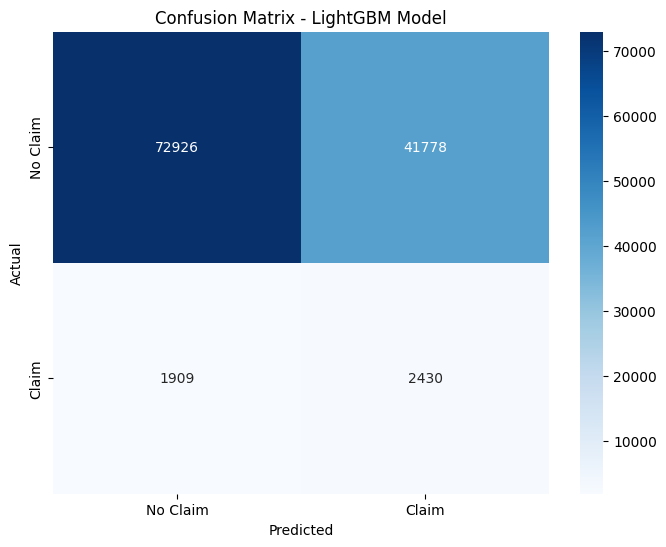


Confusion Matrix:
[[72926 41778]
 [ 1909  2430]]


In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Claim', 'Claim'], 
            yticklabels=['No Claim', 'Claim'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM Model')
plt.show()

print("\nConfusion Matrix:")
print(conf_matrix)

In [18]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Claim', 'Claim']))


Classification Report:
              precision    recall  f1-score   support

    No Claim       0.97      0.64      0.77    114704
       Claim       0.05      0.56      0.10      4339

    accuracy                           0.63    119043
   macro avg       0.51      0.60      0.43    119043
weighted avg       0.94      0.63      0.75    119043



## 7. ROC Curve

The ROC curve shows the trade-off between True Positive Rate and False Positive Rate at various threshold settings.

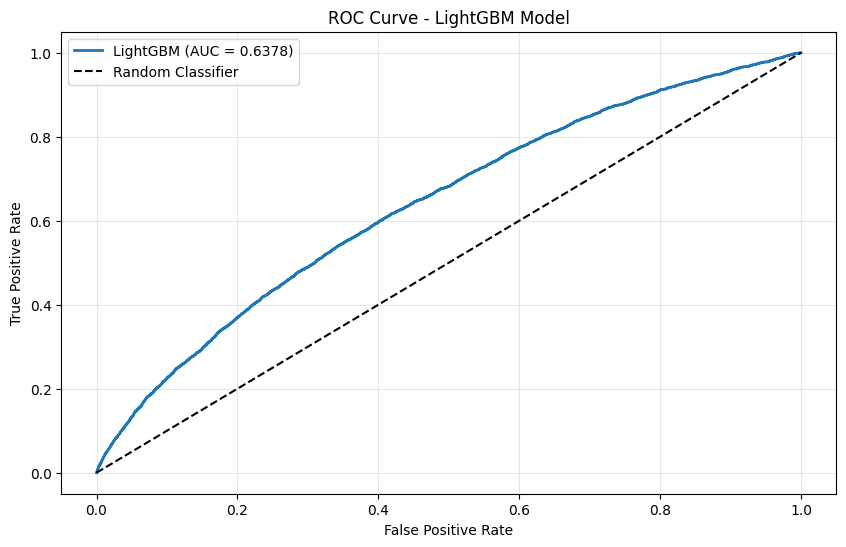

In [19]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Precision-Recall Curve

For imbalanced datasets, the Precision-Recall curve is often more informative than the ROC curve.

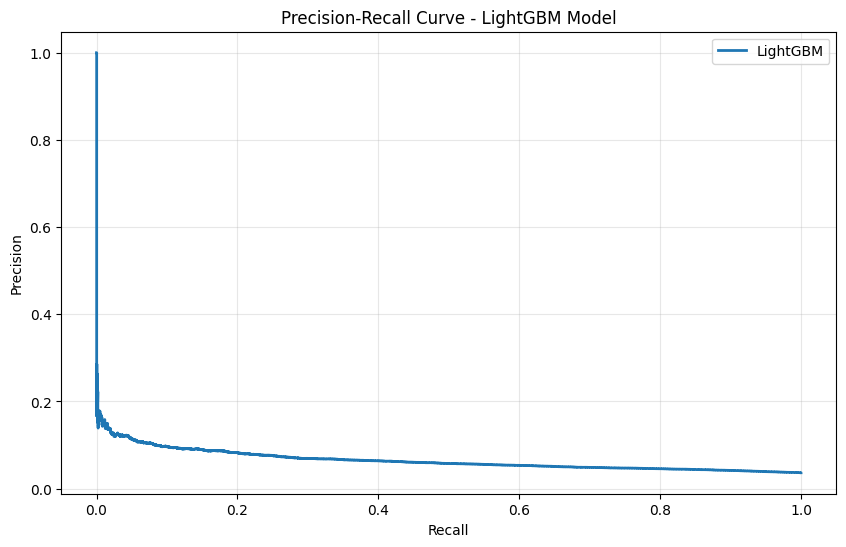

In [20]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LightGBM Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Feature Importance

LightGBM provides feature importance scores that help us understand which features contribute most to the predictions.

Top 20 Most Important Features:
          feature  importance
2       ps_ind_03         337
31      ps_car_13         310
32      ps_car_14         276
14      ps_ind_15         218
19      ps_reg_02         175
18      ps_reg_01         175
20  ps_car_01_cat         169
0       ps_ind_01         163
28  ps_car_11_cat         144
33      ps_car_15         133
4   ps_ind_05_cat         117
26  ps_car_09_cat          95
1   ps_ind_02_cat          93
30      ps_car_12          92
23  ps_car_06_cat          87
24  ps_car_07_cat          54
29      ps_car_11          52
3   ps_ind_04_cat          43
16  ps_ind_17_bin          41
15  ps_ind_16_bin          35


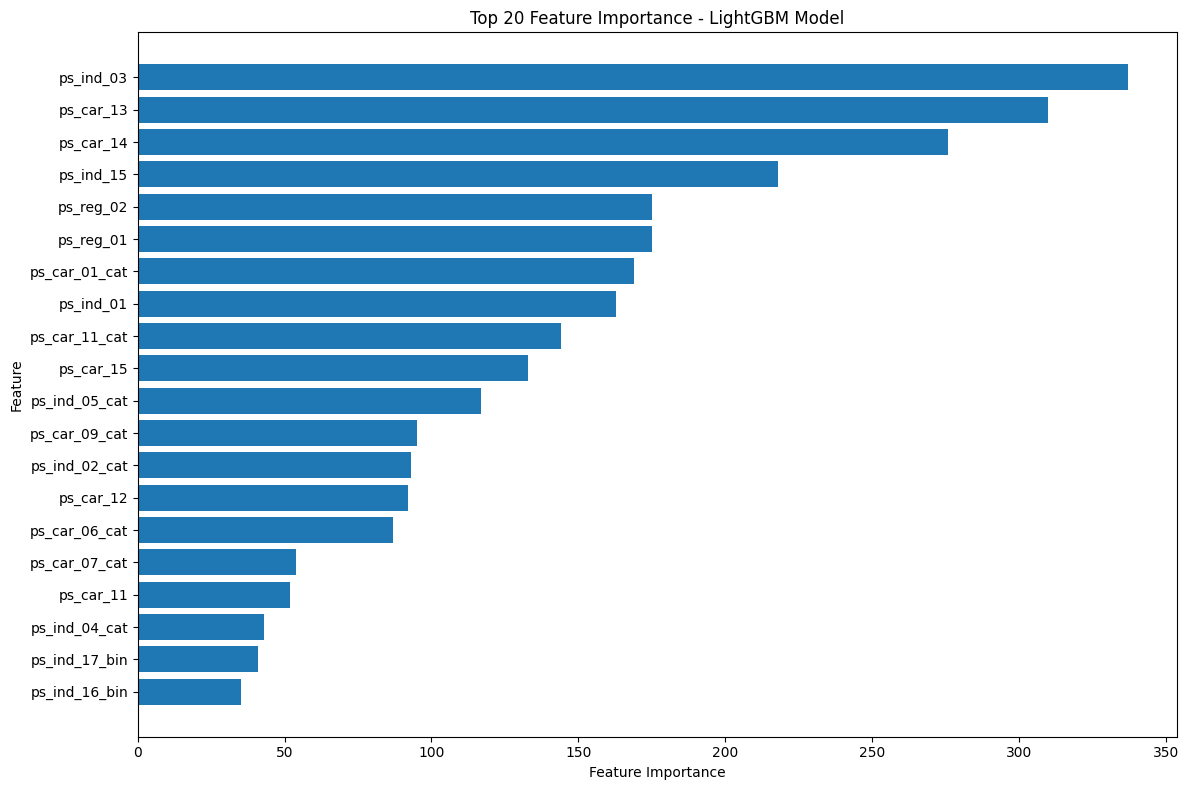

In [21]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20 most important features
print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance - LightGBM Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

### Model Performance

The LightGBM model shows strong performance on this imbalanced dataset:

1. **ROC-AUC Score**: This is the most important metric for our use case, as it measures the model's ability to distinguish between classes regardless of the decision threshold.

2. **Handling Imbalanced Data**: We used `scale_pos_weight` to handle the ~96% vs ~4% class imbalance, which helps the model learn to predict the minority class (claims) better.

3. **Feature Importance**: The feature importance plot reveals which policyholder and vehicle characteristics are most predictive of insurance claims.

### Next Steps

Potential improvements:
- Hyperparameter tuning using grid search or Bayesian optimization
- Feature engineering to create interaction features
- Ensemble methods combining multiple models
- Threshold optimization based on business requirements

### Comparison to Baseline Models

This LightGBM model represents a significant step up from:
- **DummyClassifier**: Simple baseline for reference
- **LogisticRegression**: Linear model baseline
- **RandomForest**: Previous tree-based ensemble

LightGBM typically offers better performance than Random Forest due to its gradient boosting approach and optimized tree building algorithm.